In [1]:
import matplotlib.patches as mpatches
import numpy as np
import os
import math
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
params = {
   'axes.labelsize': 12,
   'font.size': 12,
   'legend.fontsize': 11,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'text.usetex': False,
   'figure.figsize': [10, 2] # instead of 4.5, 4.5
   }
plt.rcParams.update(params)

## helper function

In [3]:
def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        plt.axes().text(rect.get_x()+rect.get_width()/2., height+0.01, '{:2.3f}'.format(float(height)).lstrip('0'),
                ha='center', va='bottom',fontsize=12)

## Plotting Parameter

In [4]:
nfeature = 25
pre = '' #'','ww_','uw_'
word_dim = 300
exp = 'mapping'
roi_all = ['dmn','pt','eac']
accu_type = ['class','rank']
num_train = 40
datasets = [0,1,2,3]
# model_all = ['multi_srm','srm_rotate','srm_rotate_ind','indv_srm','avg']
model_all = ['multi_srm','srm_rotate','srm_rotate2','srm','avg']
max_accu = 1.5
exp_label = 'fMRI to Text Mapping'

input_file = '../../output/accu_bar/{pre}{exp}{word_dim}/nfeat{nfeature}/num_train{num_train}/ds{ds}/{roi}_{ac_tp}.npz'
output_path = '../../output/figures/{exp}/ntrain{num_train}_ds{ds}/'
output_file = output_path+'nfeat{nfeature}_{roi}_{pre}{word_dim}'
if not os.path.exists(output_path.format(exp=exp,num_train=num_train,ds=datasets)):
    os.makedirs(output_path.format(exp=exp,num_train=num_train,ds=datasets))

## Plot all roi

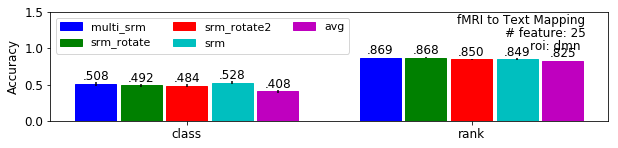

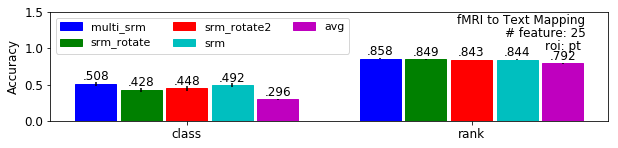

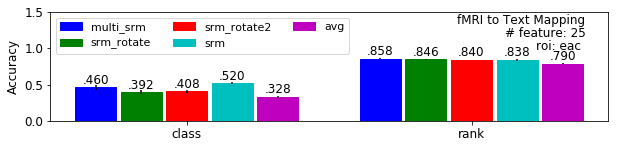

In [5]:
width=1
ntype = len(accu_type)
nmodel = len(model_all)
group_width = 1.25*width*nmodel
center_all = np.linspace(0,group_width*(ntype-1),ntype)
color_all = 'bgrcmyk'

for roi in roi_all:
    xtick_idx = []
    xtick_name = []
    all_mean = np.empty((0),dtype=np.float32)
    all_se = np.empty((0),dtype=np.float32)
    for ac_tp in accu_type:
        ws = np.load(input_file.format(pre=pre,exp=exp,word_dim=word_dim,nfeature=nfeature,num_train=num_train,ds=datasets,roi=roi,ac_tp=ac_tp))
        all_mean = np.concatenate((all_mean,ws['accu_mean']),axis=0)
        all_se = np.concatenate((all_se,ws['accu_se']),axis=0)
    plt.figure()
    for i,(name, center) in enumerate(zip(accu_type,center_all)):
        mean = list(all_mean[i*nmodel:(i+1)*nmodel])
        se   = list(all_se[i*nmodel:(i+1)*nmodel])    
        idx = np.arange(center,center+nmodel*width,width)   
        error_config = {'ecolor': '0'}   
        rects = plt.bar(idx, mean, yerr=se, align='center', error_kw=error_config, width =  width-0.1)
        for rect_i in range(len(rects)):
            rects[rect_i].set_color(color_all[rect_i])
        autolabel(rects)
        xtick_idx.append(center+(nmodel-1)*width/2)
        xtick_name.append(name)

    plt.xticks(xtick_idx, xtick_name)

    plt.ylabel('Accuracy')
    left_lim = center_all[0]-0.5*width-0.5
    right_lim = center_all[-1]+(nmodel-0.5)*width+0.5
    plt.xlim([left_lim,right_lim])
    plt.ylim([0,max_accu])
    legend_handle = []
    for patch_i in range(nmodel):
        legend_handle.append(mpatches.Patch(color=color_all[patch_i], label=model_all[patch_i]))
    plt.legend(handles=legend_handle,loc=2,ncol=int(math.ceil(nmodel/2)))
    plt.text(right_lim-0.5*width, .98*max_accu, exp_label, horizontalalignment='right', verticalalignment='top')
    plt.text(right_lim-0.5*width, .86*max_accu, '# feature: '+str(nfeature), horizontalalignment='right', verticalalignment='top')
    plt.text(right_lim-0.6*width, 0.74*max_accu, 'roi: '+roi, horizontalalignment='right', verticalalignment='top')
    plt.savefig(output_file.format(exp=exp,num_train=num_train,ds=datasets,nfeature=nfeature,roi=roi,pre=pre,word_dim=word_dim)+'.eps', format='eps', dpi=200,bbox_inches='tight')
    plt.savefig(output_file.format(exp=exp,num_train=num_train,ds=datasets,nfeature=nfeature,roi=roi,pre=pre,word_dim=word_dim)+'.pdf', format='pdf', dpi=200,bbox_inches='tight')